## Script for training ready-for-discharge (RFD) classifiers using multiple source cross-validation. 

#### TODO: implement multiple folds per source when using both MIMIC and GICU.

In [1]:
import pandas as pd
import numpy as np
import bisect
import pickle
#import yaml
from pathlib import Path

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, brier_score_loss
from sklearn.metrics import auc as auc_metric
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer, f1_score, accuracy_score
from sklearn.model_selection import PredefinedSplit

from sklearn.impute import KNNImputer

from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
original_features = [
    'airway', 'fio2', 'spo2_min', 
    'hco3', 'resp_min', 'resp_max', 
    'bp_min', 'hr_min', 'hr_max', 'pain', 
    'gcs_min', 'temp_min', 'temp_max', 
    'haemoglobin', 'k','na','creatinine','bun'
] 

config = {
    'data_sources': ['mimic'],  # 'gicu' can be included or omitted to train on MIMIC only
    'feature_set': 'extended',  # 'extended' includes demographic features
    'features': {
        'original': original_features,
        'extended': original_features + ['bmi', 'los', 'age', 'sex']
    },
    'fit_score': 'f1',  # optimise hyperparameters according to this score (e.g. 'f1')
    'n_splits': 10,  # number of repeated train:test splits to evaluate for peformance statistics
    'random_seed': 42,
    'missing_data_treatment': 'imputed',  # or 'completecase'
    'data_directory': Path('./fms/'),
    'results_directory': Path('./results'),
    'fpr_range': np.linspace(0.1, 1, 10),  # flase positive rates at which to evaluate relevant performance metrics
    'cv_folds': 5,  # number of cross-validation folds to use (currently only used when GICU is omitted)
    'test_size': 0.3  # fraction to hold out for test
}

In [3]:
features = ['bp_MAX',
 'bp_MIN',
 'bun',
 'creatinine',
 'gcs_MAX',
 'gcs_MIN',
 'haemoglobin',
 'hco3',
 'hr_MAX',
 'hr_MIN',
 'k',
 'na',
 'pain',
 'resp_MAX',
 'resp_MIN',
 'spo2_MAX',
 'spo2_MIN',
 'temp_MAX',
 'temp_MIN',
 'airway',
 'fio2',
 'bp_MEAN_GRAD',
 'bp_MIN_MAX_GRAD',
 'bp_MAX_MIN_GRAD',
 'gcs_MEAN_GRAD',
 'gcs_MIN_MAX_GRAD',
 'gcs_MAX_MIN_GRAD',
 'hr_MEAN_GRAD',
 'hr_MIN_MAX_GRAD',
 'hr_MAX_MIN_GRAD',
 'resp_MEAN_GRAD',
 'resp_MIN_MAX_GRAD',
 'resp_MAX_MIN_GRAD',
 'spo2_MEAN_GRAD',
 'spo2_MIN_MAX_GRAD',
 'spo2_MAX_MIN_GRAD',
 'temp_MEAN_GRAD',
 'temp_MIN_MAX_GRAD',
 'temp_MAX_MIN_GRAD',
 'age',
 'LOS_AC',
 'sex']

In [4]:
fm_gicu = None

In [5]:
def split_data(mimic, gicu, test_size=config['test_size'], seed=config['random_seed'], VERBOSE=True):
    
    if gicu is not None:
        # first we split the smaller GICU data according to test_size
        g_train, g_test = train_test_split(fm_gicu, test_size=test_size, random_state=seed)

        # then split MIMIC such that size of m_test equals that of g_test
        mfrac = len(g_test) / len(fm_mimic)
        
    else:
        g_train = None
        g_test = None
        mfrac = test_size
        
    m_train, m_test = train_test_split(fm_mimic, test_size=mfrac, random_state=seed)
    
    if VERBOSE:
        print("Using %.4f of MIMIC as training data" %(1-mfrac))
        print("giving test sets gicu_test:%d and mimic_test:%d" %(len(g_test) if g_test is not None else 0,len(m_test)))
    
    return m_train, m_test, g_train, g_test

In [6]:
def get_fpr_tpr_for_threshold(fpr, tpr, threshold, prob_thresholds):
    p = bisect.bisect_left(fpr, threshold)
    fpr = fpr.copy()
    fpr[p] = threshold
    return fpr[: p + 1], tpr[: p + 1], prob_thresholds[: p + 1]

def partial_auc_score(y, y_pred, threshold=0.5):
    fpr, tpr, prob_thresholds = roc_curve(y, y_pred, pos_label=1) 
    fpr_t, tpr_t, _ = get_fpr_tpr_for_threshold(fpr, tpr, threshold, prob_thresholds)
    
    return auc_metric(fpr_t,tpr_t) 

def calculate_all_metrics(ytrue, ypred, fpr_thresh):
    
    results = {}
    fpr, tpr, prob_thresholds = roc_curve(ytrue, ypred, pos_label=1) 
    fpr_t, tpr_t, cutoff = get_fpr_tpr_for_threshold(fpr, tpr, fpr_thresh, prob_thresholds)
    
    ypred_class = ypred>=cutoff[-1]
    
    results['f1'] = f1_score(ytrue, ypred_class)
    results['accuracy'] = accuracy_score(ytrue, ypred_class)
    results['sensitivity'] = tpr_t[-1]
    results['specificity'] = 1 - fpr_t[-1]
    results['pauc'] = partial_auc_score(ytrue, ypred, threshold=fpr_thresh)
    
    return results

In [7]:
def store_performance_results(ytrue, ypred, results_dict, sps, dbsource=None):
    
    auc = roc_auc_score(ytrue, ypred)
    brier = brier_score_loss(ytrue, ypred)
    
    results_dict['performance_%s' %dbsource]['auc'].append(auc)
    results_dict['performance_%s' %dbsource]['brier'].append(brier)
    
    for ff in config['fpr_range']:
        
        results = calculate_all_metrics(ytrue, ypred, ff)
        for metric, result in results.items():
            results_dict['performance_%s' %dbsource][metric]['%.2f' %ff].append(result)
    
    return results_dict

In [8]:
def optimise_return_test_scores(
    parameters_to_optimise, classifier, 
    fm_mimic, fm_gicu, config, 
    verbose=False, savename=None
):
    
    fpr_range = config['fpr_range'] 
    number_of_splits=config['n_splits']
    #features = config['features'][config['feature_set']]
    features = ['bp_MAX', 'bp_MIN', 'bun', 'creatinine', 'gcs_MAX', 'gcs_MIN', 'haemoglobin', 'hco3', 'hr_MAX', 'hr_MIN', 'k', 'na', 'pain', 'resp_MAX', 'resp_MIN', 'spo2_MAX', 'spo2_MIN', 'temp_MAX', 'temp_MIN', 'airway', 'fio2', 'bp_MEAN_GRAD', 'bp_MIN_MAX_GRAD', 'bp_MAX_MIN_GRAD', 'gcs_MEAN_GRAD', 'gcs_MIN_MAX_GRAD', 'gcs_MAX_MIN_GRAD', 'hr_MEAN_GRAD', 'hr_MIN_MAX_GRAD', 'hr_MAX_MIN_GRAD', 'resp_MEAN_GRAD', 'resp_MIN_MAX_GRAD', 'resp_MAX_MIN_GRAD', 'spo2_MEAN_GRAD', 'spo2_MIN_MAX_GRAD', 'spo2_MAX_MIN_GRAD', 'temp_MEAN_GRAD', 'temp_MIN_MAX_GRAD', 'temp_MAX_MIN_GRAD', 'age', 'LOS_AC', 'sex']
    use_gicu = 'gicu' in config['data_sources']
    
    # initialise results dictionary
    results_dict = dict()
    for dbs in ['gicu', 'mimic', 'train', 'combined']:
        
        results_dict['performance_%s' %dbs] = {
            'auc': [],
            'brier': []
        }
    
        # the following metrics are evaulated at a range of FPR values:
        performance_metrics = ['f1', 'accuracy', 'sensitivity', 'specificity', 'pauc']
        for metric in performance_metrics:
            results_dict['performance_%s' %dbs][metric] = {
                '%.2f' %ff: []
                for ff in fpr_range
            }

    params = []
    this_seed = []
    opt_clfs = []
    
    for sp in range(number_of_splits):
        
        print("Split %d" %sp)
        m_train, m_test, g_train, g_test = split_data(fm_mimic, fm_gicu, seed=sp)
        
        imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)
        imputer.fit(m_train[features])
        m_train[features] = imputer.transform(m_train[features])
        m_test[features] = imputer.transform(m_test[features])
        
        train = m_train
        combined = m_test
        
        if use_gicu:
            test_fold = [0 for i in m_train]  # 0th test fold is MIMC data
            test_fold.extend([1 for i in g_train])  # 1st test fold is GICU data
            cv_folds = PredefinedSplit(test_fold)
        else:
            cv_folds = config['cv_folds']
    
        print("Creating gridsearch.")
        clf = GridSearchCV(
            classifier, parameters_to_optimise, cv=cv_folds, 
            scoring=config['fit_score'], return_train_score=False, refit=True, verbose=True, n_jobs=-1
        )
        
        print("Running gridsearch...")
        clf.fit(train[features].to_numpy(), list(train['outcome']))
        best_params = clf.best_params_
        print("Gridsearch complete.")
        
        # evaluate performance metrics on test sets, training set and combined test sets:
        test_frames = (
            {'gicu': g_test, 'mimic': m_test, 'train': train, 'combined': combined}
            if use_gicu
            else {'mimic': m_test, 'train': train}
        )
        for dbs in test_frames.keys():
            
            ytrue = list(test_frames[dbs]['outcome'])
            ypred = clf.predict_proba(test_frames[dbs][features].to_numpy())[:,1]
            results_dict = store_performance_results(ytrue, ypred, results_dict, sp, dbsource=dbs)

        params.append(best_params)    
        this_seed.append(sp)
        opt_clfs.append(clf)
        
        if sp%20==0:
            with open(savename, 'wb') as fh:
                pickle.dump(results_dict, fh)
    
    ## add additional information to results dictionary
    results_dict['optimal_classifiers'] = opt_clfs
    results_dict['split_seeds'] = this_seed
    results_dict['optimal_params'] = params
    
    with open(savename, 'wb') as fh:
            pickle.dump(results_dict, fh)
        
    return results_dict

In [9]:
def prep_FM(FM,cc=False):
    FM = FM[FM.cohort==1] # select only cohort
    FM = FM.drop(columns=['pco2','po2']) # too much missing data
    if cc:
        print('complete-case')
        FM = FM.dropna() # drop rows with any missing data (no imputation case)
    else:
        print('imputed-case')
        FM = FM[FM.isna().sum(axis=1)<=3] # remove entries with 3 or more missing values

    max_samples = FM.outcome.value_counts().min()
    FM_1 = FM[FM.outcome==1].sample(n=max_samples)
    FM_0 = FM[FM.outcome==0].sample(n=max_samples)
    FM = pd.concat([FM_1,FM_0])
    print(FM.outcome.value_counts())
    return FM

### Random Forest:

In [10]:
PREDICT_HOURS = [0,24,48,72,96]
for when in PREDICT_HOURS:
    print(str(when)+' hrs before callout')
    fm_mimic = pd.read_pickle('pickle_vars/FM_bal_'+str(when)+'_resample_days4-8window4-4.pkl.xz')
    fm_mimic = prep_FM(fm_mimic)
    hyper_parameters = [{'n_estimators': [20,50,100],'max_features': [0.3,0.5,0.7], 'max_depth':[4,5,6,7]}]
    classifier = RandomForestClassifier(random_state=config['random_seed'], n_jobs=-1)
    results_fname = 'results/rf_'+str(when)+'_results.pickle'
    rf_results = optimise_return_test_scores(
    hyper_parameters, classifier, fm_mimic, fm_gicu, 
    config, verbose=False, savename=results_fname)   

0 hrs before callout
imputed-case
outcome
1    3832
0    3832
Name: count, dtype: int64
Split 0
Using 0.7000 of MIMIC as training data
giving test sets gicu_test:0 and mimic_test:2300
Creating gridsearch.
Running gridsearch...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Gridsearch complete.
Split 1
Using 0.7000 of MIMIC as training data
giving test sets gicu_test:0 and mimic_test:2300
Creating gridsearch.
Running gridsearch...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Gridsearch complete.
Split 2
Using 0.7000 of MIMIC as training data
giving test sets gicu_test:0 and mimic_test:2300
Creating gridsearch.
Running gridsearch...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Gridsearch complete.
Split 3
Using 0.7000 of MIMIC as training data
giving test sets gicu_test:0 and mimic_test:2300
Creating gridsearch.
Running gridsearch...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Gridsearch complete.
Split 4
Using 0.7000 of 

**Complete case**

In [11]:
PREDICT_HOURS = [0,24,48,72,96]
for when in PREDICT_HOURS:
    print(str(when)+' hrs before callout')
    fm_mimic = pd.read_pickle('pickle_vars/FM_bal_'+str(when)+'_resample_days4-8window4-4.pkl.xz')
    fm_mimic = prep_FM(fm_mimic,cc=True)
    hyper_parameters = [{'n_estimators': [20,50,100],'max_features': [0.3,0.5,0.7], 'max_depth':[4,5,6,7]}]
    classifier = RandomForestClassifier(random_state=config['random_seed'], n_jobs=-1)
    results_fname = 'results/rf_CC_'+str(when)+'_results.pickle'
    rf_results = optimise_return_test_scores(
    hyper_parameters, classifier, fm_mimic, fm_gicu, 
    config, verbose=False, savename=results_fname)   

0 hrs before callout
complete-case
outcome
1    956
0    956
Name: count, dtype: int64
Split 0
Using 0.7000 of MIMIC as training data
giving test sets gicu_test:0 and mimic_test:574
Creating gridsearch.
Running gridsearch...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Gridsearch complete.
Split 1
Using 0.7000 of MIMIC as training data
giving test sets gicu_test:0 and mimic_test:574
Creating gridsearch.
Running gridsearch...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Gridsearch complete.
Split 2
Using 0.7000 of MIMIC as training data
giving test sets gicu_test:0 and mimic_test:574
Creating gridsearch.
Running gridsearch...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Gridsearch complete.
Split 3
Using 0.7000 of MIMIC as training data
giving test sets gicu_test:0 and mimic_test:574
Creating gridsearch.
Running gridsearch...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Gridsearch complete.
Split 4
Using 0.7000 of MIMIC

### EBM

In [ ]:
PREDICT_HOURS = [0,24,48,72,96]
for when in PREDICT_HOURS:
    print(str(when)+' hrs before callout')
    fm_mimic = pd.read_pickle('pickle_vars/FM_bal_'+str(when)+'_resample_days4-8window4-4.pkl.xz')
    fm_mimic = prep_FM(fm_mimic)
    hyper_parameters = {'max_bins':[4096],'interactions': [0]}
    classifier = ExplainableBoostingClassifier()
    results_fname = 'results/ebm_'+str(when)+'_results.pickle'
    ebm_results = optimise_return_test_scores(
    hyper_parameters, classifier, fm_mimic, fm_gicu, 
    config, verbose=False, savename=results_fname)    

**Complete case**

In [ ]:
PREDICT_HOURS = [0,24,48,72,96]
for when in PREDICT_HOURS:
    print(str(when)+' hrs before callout')
    fm_mimic = pd.read_pickle('pickle_vars/FM_bal_'+str(when)+'_resample_days4-8window4-4.pkl.xz')
    fm_mimic = prep_FM(fm_mimic,cc=True)
    hyper_parameters = {'max_bins':[4096],'interactions': [0]}
    classifier = ExplainableBoostingClassifier()
    results_fname = 'results/ebm_CC_'+str(when)+'_results.pickle'
    ebm_results = optimise_return_test_scores(
    hyper_parameters, classifier, fm_mimic, fm_gicu, 
    config, verbose=False, savename=results_fname)    

### other stuff

#### Now we save one of each trained classifier along with the train and test data for that split:

In [14]:
ebm = ebm_results['optimal_classifiers'][0]

In [15]:
seed = ebm_results['split_seeds'][0]

In [16]:
m_train, m_test, _, _ = split_data(fm_mimic, fm_gicu, seed=seed)

Using 0.7000 of MIMIC as training data
giving test sets gicu_test:0 and mimic_test:212


In [ ]:
with open(config['results_directory'] / 'rf.pickle', 'wb') as out_file:
    pickle.dump(rf, out_file)

In [ ]:
m_train.to_csv(config['results_directory'] / 'training_data.csv')
m_test.to_csv(config['results_directory'] / 'test_data.csv')

#### Quick sanity check of classifier performance:

In [25]:
def roc(df, clf):
    ytrue = df['outcome']
    ypred = clf.predict_proba(df[features].to_numpy())[:,1]
    fpr, tpr, _ = roc_curve(ytrue, ypred)
    auc = auc_metric(fpr, tpr)
    return fpr, tpr, auc

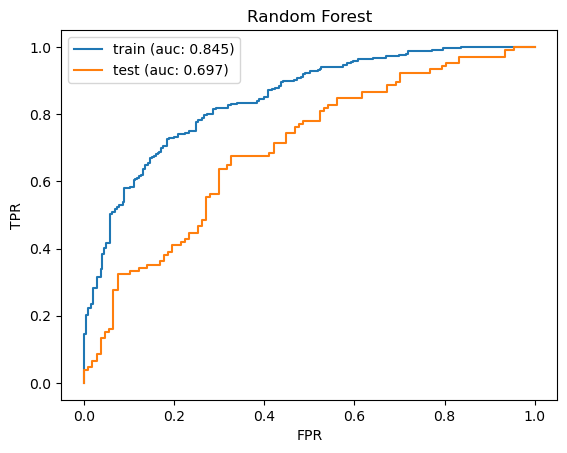

In [19]:
imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)
imputer.fit(m_train[features])
m_train[features] = imputer.transform(m_train[features])
m_test[features] = imputer.transform(m_test[features])

fpr_train, tpr_train, auc_train = roc(m_train, ebm)
fpr_test, tpr_test, auc_test = roc(m_test, ebm)

plt.plot(fpr_train, tpr_train, label='train (auc: %.3f)' % auc_train)
plt.plot(fpr_test, tpr_test, label='test (auc: %.3f)' % auc_test)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Random Forest')
plt.legend();

### AUC graph

In [12]:
def roc(df, clf):
    ytrue = df['outcome']
    ypred = clf.predict_proba(df[features].to_numpy())[:,1]
    fpr, tpr, _ = roc_curve(ytrue, ypred)
    auc = auc_metric(fpr, tpr)
    return fpr, tpr, auc

0 hrs before callout
imputed-case
outcome
1    3832
0    3832
Name: count, dtype: int64
24 hrs before callout
imputed-case
outcome
1    2629
0    2629
Name: count, dtype: int64
48 hrs before callout
imputed-case
outcome
1    1640
0    1640
Name: count, dtype: int64
72 hrs before callout
imputed-case
outcome
1    1130
0    1130
Name: count, dtype: int64
96 hrs before callout
imputed-case
outcome
1    826
0    826
Name: count, dtype: int64


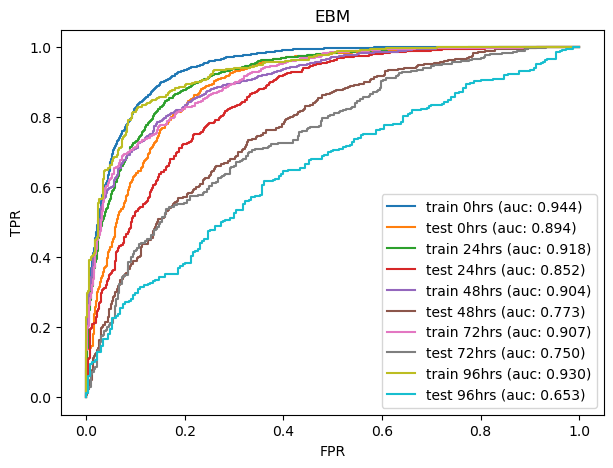

In [23]:
fig, ax = plt.subplots(1)
PREDICT_HOURS = [0,24,48,72,96]
for when in PREDICT_HOURS:
    print(str(when)+' hrs before callout')
    fm_mimic = pd.read_pickle('pickle_vars/FM_bal_'+str(when)+'_resample_days4-8window4-4.pkl.xz')
    fm_mimic = prep_FM(fm_mimic)
    
    m_train, m_test = train_test_split(fm_mimic, test_size=0.3)
    
    imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)
    imputer.fit(m_train[features])
    m_train[features] = imputer.transform(m_train[features])
    m_test[features] = imputer.transform(m_test[features])
    
    ebm = ExplainableBoostingClassifier().fit(m_train[features],m_train['outcome'])

    fpr_train, tpr_train, auc_train = roc(m_train, ebm)
    fpr_test, tpr_test, auc_test = roc(m_test, ebm)


    ax.plot(fpr_train, tpr_train, label='train '+str(when)+'hrs (auc: %.3f)' % auc_train)
    ax.plot(fpr_test, tpr_test, label='test '+str(when)+'hrs (auc: %.3f)' % auc_test)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('EBM')
ax.legend();
fig.set_size_inches(7, 5)
fig.savefig('figures/ebm_TPR_FPR.png', dpi=500,bbox_inches = "tight")